# Project discrete optimization: a walk to the park

*Selected Topics in Mathematical Optimization: 2017-2018*

**Michiel Stock** ([email](michiel.stock@ugent.be))

![](Figures/logo.png)

Daan Van Hauwermeiren, Bram De Jaegher

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import json

%matplotlib inline

blue = '#264653'
green = '#2a9d8f'
yellow = '#e9c46a'
orange = '#f4a261'
red = '#e76f51'
black = '#50514F'

In this project we will study a fictitious city (you can imagine it to be the capital of your favourite fantasy setting). A map of this city is given below.

![A city with streets and parks.](Figures/city_map.png)

Every point on this map is a crossing, and every grey line is a street between two crossings. Every street is a straight line and the length of the street is just the Euclidean distance between the two crossings.

This city also has some parks, indicated in green:

- **park A** at the top left corner;
- **park B** on the right, traversing top to bottom;
- **park C**, the little circular region in the middle.

This city can be represented as a weighted graph. Every vertex has an integer identifier and is associated with an $x,y$ coordinate. We have also three lists containing the indices of the vertices lying in the parks.

In [29]:
with open('Data/city.json', 'r') as fh:
    city = json.load(fh)
    
edges = list(map(tuple, city['edges']))
coordinates = city['coordinates']
vertices = list(city['vertices'])

park_A = city['parks']['A']
park_B = city['parks']['B']
park_C = city['parks']['C']

The main research question of this project is:

> What is the shortest path from *any* vertex to a vertex in a park?

As a first heuristic, we can use the minimum spanning tree on the graph. As seen in the theory, this is the tree tree that connects all vertices and has the lowest cost. From this tree, there is a single path from every edge to every other edge.

In a second step, we will use shortest path algorithms to find the true shortest path for every vertex.

**ASSIGNMENTS**

1. Find the minimum spanning tree for this graph.
    - Make a plot of the minimum spanning tree for this graph.
    - Compute the distance from any vertex on the minimum spanning tree to the closest vertex lying in a park.
    - Make a histogram of these distances (remove distances equal to zero, i.e. from vertices already in a park).
2. Compute the shortest distances from any vertex to the closest vertex (note that all shortest paths together will be a forest).
    - Implement this in an efficient way, **not** by using A* in a for-loop!
    - Show your solution on a plot, color the vertices according to the distances to the closest park and add arrows to indicate which vertex to take.
    - Show for every vertex whether park A, B or C is the closest.
    - Make a histogram of these distances (remove distances equal to zero, i.e. from vertices already in a park). Compare with the minimum spanning tree.

Some guidelines for completing this project:

- Write clear code with human-readable names and comments where needed. Add a (basic) docstring to all your functions.
- Make clear figures with ax labels, titles etc.
- Always provide some interpretation of the results.
- You **can** recycle and modify code from earlier chapters or other sources. Clearly indicate where you obtained this code from (you can add a hyperlink to the original source).

Finally, some hints that can help you do this project efficiently:

- Carefully read all assignments, assignment 1 and 2 essentially ask the same thing.
- The shortest path from vertex A to vertex B is the same as from vertex B to vertex A.
- If vertex C is on the shortest path from vertex A to vertex B, then you also found the shortest path from vertex C to vertex B. 

## General functions definitions & loading libraries

In [30]:
import heapq
from functools import reduce
import operator
import itertools

Prims algorithm, implemented in course

In [67]:
def prim(vertices, edges, start, add_weights=False):
    """
    Prim's algorithm for finding a minimum spanning tree.

    Inputs :
        - vertices : a set of the vertices of the Graph
        - edges : a list of weighted edges (e.g. (0.7, 'A', 'B') for an
                    edge from node A to node B with weigth 0.7)
        - start : an edge to start with

    Output:
        - edges : a minumum spanning tree represented as a list of edges
        - total_cost : total cost of the tree
    """
    adj_list = edges_to_adj_list(edges)
    # list of tuples describing the edges starting from the start
    # vertix, with weights, i.e. the candidate edges
    to_check = [(w, start, v_new) for w, v_new in adj_list[start]]
    # heapify the list (~sorting)
    heapq.heapify(to_check)
    # for every node connected to the
    #dist_to_mst = {i : (w, start) for w, i in adj_list.pop(start)}
    mst_edges = []
    mst_vertices = set([start])
    total_cost = 0
    while to_check:
        # get the edge with the lowest cost connected to the vertix
        cost, v_in_mst, v_new = heapq.heappop(to_check)
        # check if the vertex is not in the current list of vertices
        # aka the path that is constructed
        if v_new not in mst_vertices:
            # if not, add to mst
            if add_weights:
                mst_edges.append((cost, v_in_mst, v_new))
            else:
                mst_edges.append((v_in_mst, v_new))
            mst_vertices.add(v_new)
            total_cost += cost
            # update the heap with candidate edges: adding the edges starting
            # from the newly added vertix
            for cost, v in adj_list[v_new]:
                heapq.heappush(to_check, (cost, v_new, v))    
    return mst_edges, total_cost

Edge to adjacency list function, from course

In [32]:
def edges_to_adj_list(edges):
    """
    Turns a list of edges in an adjecency list (implemented as a list).
    Edges don't have to be doubled, will automatically be symmetric

    Input:
        - edges : a list of weighted edges (e.g. (0.7, 'A', 'B') for an
                    edge from node A to node B with weigth 0.7)

    Output:
        - adj_list : a dict of a set of weighted edges
    """
    adj_list = {}
    for w, i, j in edges:
        for v in (i, j):
            if v not in adj_list:
                adj_list[v] = set([])
        adj_list[i].add((w, j))
        adj_list[j].add((w, i))
    return adj_list

Distance functions, adapted from course

In [33]:
manhattan_distance = lambda x, y : sum([abs(xi - yi) for xi, yi in zip(coordinates[x], coordinates[y])])
euclidean_distance = lambda x, y : sum([(xi - yi)**2 for xi, yi in zip(coordinates[x], coordinates[y])])**0.5

A* algorithm, from course

In [34]:
def a_star(graph, source, sink, heuristic):
    """
    Implementation of the A* shortest path algorithm
    Inputs:
        - graph : dict representing the graph
        - source : the source node
        - sink : the sink node (optional)
        - heuristic : a function with the heuristic for the shortest path between two nodes
    Ouput:
        - distance : dict with the distances of the nodes to the source
        - came_from : dict with for each node the previous node in the shortest
                    path from the source
    """
    distance = {v : np.inf for v in graph.keys()}
    # vertices_to_check is a heap containing the estimated distance
    # of a given node to a source
    vertices_to_check = [(heuristic(source, sink), source)]
    previous = {}

    distance[source] = 0

    while vertices_to_check:
        heuristic_dist, current = heapq.heappop(vertices_to_check)
        if current == sink:
            return reconstruct_path(previous, source, sink), distance[sink]
        for dist_current_neighbor, neighbor in graph[current]:
            new_dist_from_source = distance[current] + dist_current_neighbor
            if new_dist_from_source < distance[neighbor]:
                distance[neighbor] = new_dist_from_source
                min_dist_neighbor_source = distance[neighbor] +\
                        heuristic(neighbor, sink)
                heapq.heappush(vertices_to_check, (min_dist_neighbor_source, neighbor))
                previous[neighbor] = current

Reconstruct shortest path found by A*, from course

In [35]:
def reconstruct_path(previous, source, sink):
    """
    Reconstruct the path from the output of the Dijkstra algorithm.

    Inputs:
            - previous : a dict with the previous node in the path
            - source : the source node
            - sink : the sink node
    Ouput:
            - the shortest path from source to sink
    """
    if sink not in previous:
        return []
    # V := sink   \\ path is reconstructed backwards
    v = sink
    # path := [V]  \\ path is a list of nodes
    path = [v]
    # while V is not source
    while v is not source:
        # V := previous node in path
        v = previous[v]
        # add V in beginning of the path
        path = [v] + path
    return path

Plot functions

In [70]:
def plot_path(path, ax, color=red):
    """
    Plot path on ax
    """
    for i in range(len(path)-1):
        i1, j1 = coordinates[path[i]]
        i2, j2 = coordinates[path[i+1]]
        ax.plot([i1, i2], [j1, j2], c=color, lw=2)

## Assignment 1: Find the minimum spanning tree for this graph

### Make a plot of the minimum spanning tree for this graph.

Use Prim algorithm to find minimum spanning tree 

In [37]:
start = vertices[0]
mst_edges, total_cost = prim(vertices=vertices,edges=edges,start=1, add_weights=True)

Plot minimum spanning tree

(0, 150)

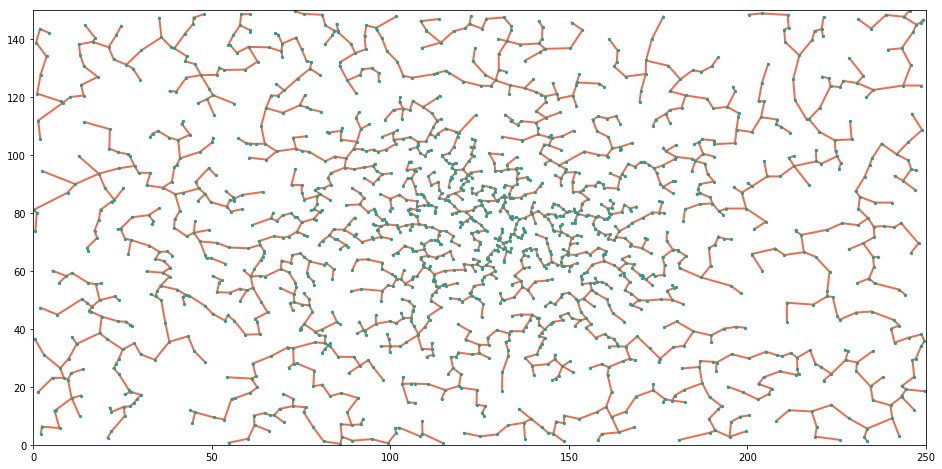

In [38]:
fig, ax = plt.subplots(figsize=(16,8))
X = np.array(coordinates)
# plot with links
ax.scatter(X[:,0], X[:,1], s=5, color=green, zorder=2)
for w, i, j in mst_edges:
    ax.plot([X[i,0], X[j,0]], [X[i,1], X[j,1]], color=red, zorder=1, lw=2)
ax.set_xlim(0,250)
ax.set_ylim(0,150)

### Compute the distance from any vertex on the minimum spanning tree to the closest vertex lying in a park. 

In [39]:
# Convert to adjacency list representation
mst_adj_lst = edges_to_adj_list(mst_edges)

# Remove park nodes
graph_noparknodes = graph.copy()
__ = [graph_noparknodes.pop(i) for i in park_A + park_B + park_C]

# Find shortest path for all vertices
out,path_length,closest_sink = compute_shortest_path_shortcut(graph_noparknodes, graph, vertices_edges_park, euclidean_distance)

### Make a histogram of these distances (remove distances equal to zero, i.e. from vertices already in a park).

## Assignment 2: Compute the shortest distances from any vertex to the closest vertex in a park 

### Implement this in an efficient way, not by using A* in a for-loop!

**Step 1: **Get vertices on the edges of the park, the shortest path will always end at the edge of a park (*reducing number of sinks to test*)

In [40]:
def get_vertices_at_edge_park(vertices_park):
    '''
    Returns vertices lying on the edge of the park by looking at the connections to vertices outside the park
    '''
    # edges with only one vertex in the park:
    # edges going in or out of the park
    _filter = [(i[1] in vertices_park) ^ (i[2] in vertices_park) for i in edges]
    # filter list of edges with boolean list
    edges_park = list(itertools.compress(edges, _filter))
    # no distances needed, so remove them
    edges_park_nodistance = [(i[1], i[2]) for i in edges_park]
    # get vertices of the edges going in or out of the park
    vertices_edges_park = np.unique(edges_park_nodistance)
    # slice to have only the vertices inside the park
    return vertices_edges_park[np.isin(vertices_edges_park, vertices_park)]

In [41]:
vertices_edges_park = get_vertices_at_edge_park(park_A + park_B + park_C)

Plotting result, vertices at the edges of the park are bigger

(0, 150)

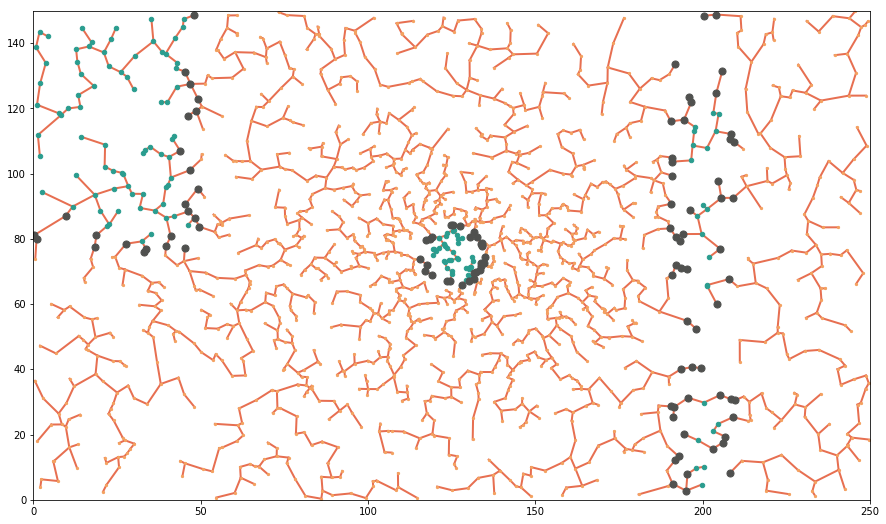

In [42]:
fig, ax = plt.subplots(figsize=(15,9))
X = np.array(coordinates)
# plot with links
ax.scatter(X[:,0], X[:,1], s=5, color=orange, zorder=2)
# plot parks
allparks = park_A + park_B + park_C
ax.scatter(X[allparks,0], X[allparks,1], s=20, color=green, zorder=2)
# plot vertices at edge of parks
ax.scatter(X[vertices_edges_park,0], X[vertices_edges_park,1], s=50, color=black, zorder=2)

for w, i, j in mst_edges:
    ax.plot([X[i,0], X[j,0]], [X[i,1], X[j,1]], color=red, zorder=1, lw=2)

ax.set_xlim(0,250)
ax.set_ylim(0,150)

**Step 2:** Loop over all vertices and find the closest path (WIP)

Function definitions

In [19]:
def find_closest_park(vertex, vertices_edges_park, dist_measure):
    '''
    returns the vertex of the closest park
    '''
    distance_lst = np.array(list(map(lambda i: dist_measure(vertex, i), vertices_edges_park)))
    return vertices_edges_park[distance_lst.argmin()]

def compute_shortest_path_shortcut(graph_queu, fullgraph, vertices_edges_park, dist_measure):
    shortestpaths = []
    shortestpath_length = []
    shortestpath_allvertices = []
    closest_sink = []
    
    while len(list(graph_queu.keys())):
        source = list(graph_queu.keys())[0]
        
        # test if source is already in one of the shortest paths
        if source in shortestpath_allvertices:
            __ = graph_queu.pop(source)
            continue
        else:
            sink = find_closest_park(source, vertices_edges_park, dist_measure)
            path_astar, length_astar = a_star(graph=fullgraph, source=source, sink=sink,
                                              heuristic=dist_measure)
            
            shortestpaths.append(path_astar)
            shortestpath_length.append(length_astar)
            closest_sink.append(path_astar.pop())
            
            shortestpath_allvertices = np.unique(reduce(operator.add, shortestpaths))
        
            __ = graph_queu.pop(source)
        
        #print(niter, len(list(graph_queu.keys())))
        #niter += 1
    return shortestpaths, shortestpath_length, closest_sink

Find shortest path, distance and sinks:

In [75]:
# Convert to adjacency list representation
graph = edges_to_adj_list(edges)

# Remove the vertices that are lying in a park
graph_noparknodes = graph.copy()
__ = [graph_noparknodes.pop(i) for i in park_A + park_B + park_C]

# Compute the shortest path from each vertex
#shortest_paths,path_lengths,closest_sinks = compute_shortest_path_shortcut(graph_noparknodes, graph, vertices_edges_park, euclidean_distance)

In [76]:
%%time
shortest_paths,path_lengths,closest_sinks = compute_shortest_path_shortcut(graph_noparknodes, graph, vertices_edges_park, euclidean_distance)

CPU times: user 3.66 s, sys: 3.96 ms, total: 3.66 s
Wall time: 3.66 s


**Step3:** Plotting shortest paths

(0, 150)

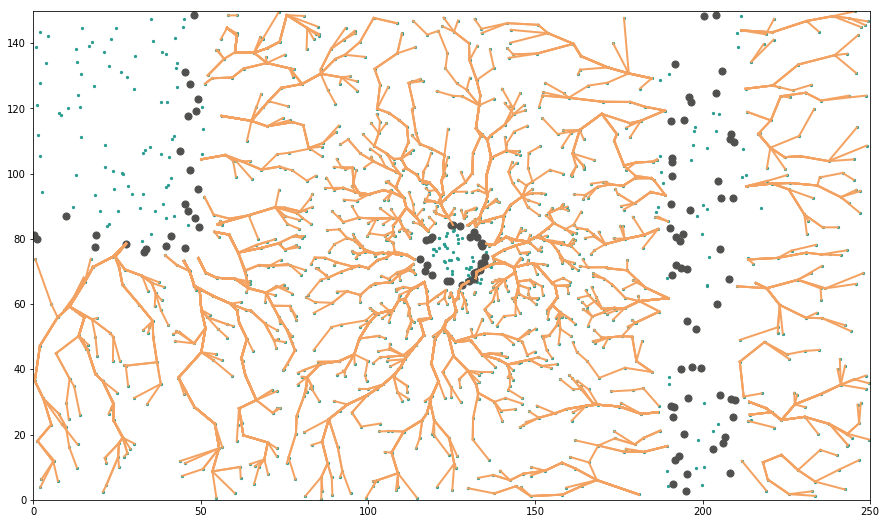

In [71]:
fig, ax = plt.subplots(figsize=(15, 9))
X = np.array(coordinates)
# plot with links
ax.scatter(X[:,0], X[:,1], s=5, color=green, zorder=2)
# plot vertices at edge of parks
ax.scatter(X[vertices_edges_park,0], X[vertices_edges_park,1], s=50, color=black, zorder=2)
for path_astar in out:
    plot_path(path_astar, ax, orange)
    

ax.set_xlim(0,250)
ax.set_ylim(0,150)

### Show your solution on a plot, color the vertices according to the distances to the closest park and add arrows to indicate which vertex to take.

### Show for every vertex whether park A, B or C is the closest.

### Make a histogram of these distances (remove distances equal to zero, i.e. from vertices already in a park).

### Compare with the minimum spanning tree.

### ZandBak

### improving speed

In [ ]:
def compute_shortest_path_shortcut(graph_queu, fullgraph, vertices_edges_park, dist_measure):
    shortestpaths = []
    shortestpath_length = []
    shortestpath_allvertices = []
    closest_sink = []
    
    while len(list(graph_queu.keys())):
        source = list(graph_queu.keys())[0]
        
        # test if source is already in one of the shortest paths
        if source in shortestpath_allvertices:
            __ = graph_queu.pop(source)
            continue
        else:
            sink = find_closest_park(source, vertices_edges_park, dist_measure)
            path_astar, length_astar = a_star(graph=fullgraph, source=source, sink=sink,
                                              heuristic=dist_measure)
            
            shortestpaths.append(path_astar)
            shortestpath_length.append(length_astar)
            closest_sink.append(path_astar.pop())
            
            vertices_edges_park.append(source)
            
            shortestpath_allvertices = np.unique(reduce(operator.add, shortestpaths))
        
            __ = graph_queu.pop(source)
        
        #print(niter, len(list(graph_queu.keys())))
        #niter += 1
    return shortestpaths, shortestpath_length, closest_sink

#### test shortest path

In [ ]:
%%time
graph = edges_to_adj_list(edges)
path_astar, length_astar = a_star(graph, source=300, sink=100, heuristic=euclidean_distance)

In [ ]:
fig, ax = plt.subplots()
X = np.array(coordinates)
# plot with links
ax.scatter(X[:,0], X[:,1], s=5, color=green, zorder=2)
add_path(path_astar, ax, orange)
ax.set_xlim(0,250)
ax.set_ylim(0,150)